# MODIS file processing

#### First working with the old climatology. (new is formatted wrong)

__From Robert Pincus on processing:__  

As you’re likely aware there are two sets of pixel counts, one related to Cloud_Retrieval_Fraction_Total and the other to Cloud_Mask_Fraction. You should normalize the by the first. I include some notes based on an exchange between myself, Mark Zelinka (LLNL)  and Kerry Meyer (NASA) below. Let me know if there’s an remaining confusion.

"For this, I think your Option #1 is correct, using the sum of the non-PCL and PCL Cloud_Optical_Thickness joint histograms (vs CTP) as the numerator, and Cloud_Retrieval_Fraction_Total Pixel_Counts as the denominator. Because the cloud mask and the cloud optical properties retrievals define daytime slightly differently (using different thresholds on solar zenith angle), your denominator in Option #2 is a slightly larger “daytime” pixel population particularly near the terminator, and thus will yield fractions somewhat smaller than they should be.

Of course, using the Cloud_Optical_Thickness joint histograms will only yield the successful retrieval fractions that, because they do not include pixels for which the optical property retrievals fail, are inherently smaller than the cloud fraction derived from the cloud mask. But I assume from your past experience with our COSP products that you’re well aware of that.

Ideally, you could just use the Cloud_Retrieval_Fraction_Total mean itself without any manipulation, but that includes only our non-PCL [partly-cloudy and hence unreliable] pixels.”

### Add paths to run locally or off Cheyenne or Casper 
(what is the difference between these two again?)

In [204]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')

sys.path.append('/Users/jonahshaw/git_repos/CESM2_analysis/')
sys.path.append('/Users/jonahshaw/git_repos/CESM2_analysis/Common/')

# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

In [7]:
from interp_functions import *

In [8]:
chey_modis_dir = '/glade/u/home/jonahshaw/obs/COSP/MODIS/latest/'

chey_modis_climo = 'MCD06COSP_M3_MODIS.200301to202012.climo.nc'
chey_modis_file = 'MCD06COSP_M3_MODIS.A2003001.061.2020181145828.nc'

chey_modis_climopath = '%s/%s' % (chey_modis_dir,chey_modis_climo)
chey_modis_filepath = '%s/%s' % (chey_modis_dir,chey_modis_file)

In [108]:
save_dir = '/glade/u/home/jonahshaw/w/archive/taylor_files/cam4_1deg_release_amip'
check_file = 'cam4_1deg_release_amip.CLDTHCK_MODIS.nc'

In [109]:
ex_file = xr.open_dataset('%s/%s' % (save_dir,check_file))

### Work with a single file

The climatology calculation removes our ability to mask correctly, so I need to produce the histogram variable for each monthly output.

In [314]:
def proc_MCD06COSP_M3_MODIS(filename,inpath,outpath,test=False):
    '''
    filename: netCDF file name
    inpath: directory where the file should be read from
    outpath: directory where the processed file should be saved
    '''
    
    fullfile = '%s/%s' % (inpath,filename)
    
    taupres_histo, taupres_histo_pcl, cld_counts = open_groups(fullfile)
    
    # normalize the Total PCL counts by the total counts
    histo_normed = normalize_histo(taupres_histo, taupres_histo_pcl, cld_counts)
#     histo_normed.name = 'MODIS_CLD_HISTO'  
    
    # add appropriate time coordinate:
    histo_normed = add_time_coord(filename,histo_normed)
#     histo_normed = add_time_coord(filename,histo_normed.to_dataset())
    
#     return histo_normed
    
    if not test:
        histo_normed.to_netcdf('%s/%s' % (outpath,filename)) # this is being weird with coordinates/variable names
    else:
        return histo_normed

def open_groups(filename):
    
    # Optical thickness / pressure histogram for cloudy retrievals
    taupres_histo = xr.open_dataset(filename,group='Cloud_Optical_Thickness_Total',engine='netcdf4')
    taupres_histo = taupres_histo['JHisto_vs_Cloud_Top_Pressure'].rename(
        {'jhisto_cloud_optical_thickness_total_7':'COT','jhisto_cloud_top_pressure_7':'PRES'})
    
    # Optical thickness / pressure histogram for partly cloudy retrievals
    taupres_histo_pcl = xr.open_dataset(filename,group='Cloud_Optical_Thickness_PCL_Total',engine='netcdf4')
    taupres_histo_pcl = taupres_histo_pcl['JHisto_vs_Cloud_Top_Pressure'].rename(
        {'jhisto_cloud_optical_thickness_pcl_total_7':'COT','jhisto_cloud_top_pressure_7':'PRES'})

    
    # Total counts for satellite retrievals (normalization)
    cld_counts = xr.open_dataset(filename,group='Cloud_Retrieval_Fraction_Total',engine='netcdf4')
    cld_counts = cld_counts['Pixel_Counts']
    
    return taupres_histo, taupres_histo_pcl, cld_counts
        
def normalize_histo(taupres_histo, taupres_histo_pcl, cld_counts):
    
    histo_counts_all = taupres_histo + taupres_histo_pcl # adds histograms for both cloudy and partly cloudy scenes
    histo_normed = (histo_counts_all / cld_counts).transpose("latitude", "longitude","COT","PRES")
    
    histo_normed = histo_normed.assign_attrs(taupres_histo.attrs) # copy attributes over
    
    histo_normed.name = 'MODIS_CLD_HISTO'
    histo_normed = histo_normed.to_dataset()
    
    # mask with total counts
    mask = cld_counts > 300 # same limit as with MISR
    
    histo_normed['cloud_mask'] = mask.transpose("latitude", "longitude") # this becomes a coordinate, which is great?
    
    # Set latitude to be centered around the equator.
    histo_normed = histo_normed.assign_coords(latitude=(histo_normed.latitude - 90),longitude=histo_normed.longitude)
    
    return histo_normed

def add_time_coord(filename,da):
    
    # add appropriate time coordinate:
    date = filename.split('.')[1]
    yr = date[1:5]
    day = date[5:]
    month = int(day) // 30 + 1
#     print('month (dict): ',month_lookup[day])
#     print('month: ',int(day) // 30 + 1)
    
    months_since = month+12*(int(yr)-2000)
    
#     print('date: ',date)
#     print("months since 1999-12-01: ",months_since)
    
    da = da.assign_coords({'time':months_since})

    da['time'].attrs['calendar'] = '360_day'
    da['time'].attrs['units'] = "months since 1999-12-01"

    da = xr.decode_cf(da)
    
    return da

# This dictionary takes the day and returns the month (replaced by using // 30)
month_lookup = {'001':1,'032':2,'060':3,'091':4,'121':5,'152':6,
                '182':7,'213':8,'244':9,'274':10,'305':11,'335':12,
                '061':3,'092':4,'122':5,'153':6,'183':7,'214':8,
                '245':9,'275':10,'306':11,'336':12}

### Get a list of the files we want.

In [228]:
modis_paths = glob.glob('%s/MCD06COSP_M3_MODIS.A**.nc' % chey_modis_dir)
modis_files = [os.path.basename(x) for x in modis_paths]
modis_files.sort()

# files = os.listdir(chey_modis_dir)
# modis_files = [i for i in files if 'MCD06COSP_M3_MODIS.A' in i] # not u

In [319]:
modis_out_dir = '/glade/u/home/jonahshaw/w/obs/MODIS/processed_histograms'

for i in modis_files:
#     add_time_coord(i,test)
    print(i)
    proc_MCD06COSP_M3_MODIS(i,chey_modis_dir,modis_out_dir,test=False)

MCD06COSP_M3_MODIS.A2003001.061.2020181145828.nc
MCD06COSP_M3_MODIS.A2003032.061.2020181145826.nc
MCD06COSP_M3_MODIS.A2003060.061.2020181145844.nc
MCD06COSP_M3_MODIS.A2003091.061.2020181145836.nc
MCD06COSP_M3_MODIS.A2003121.061.2020181145829.nc
MCD06COSP_M3_MODIS.A2003152.061.2020181145835.nc
MCD06COSP_M3_MODIS.A2003182.061.2020181145902.nc
MCD06COSP_M3_MODIS.A2003213.061.2020181145916.nc
MCD06COSP_M3_MODIS.A2003244.061.2020181145926.nc
MCD06COSP_M3_MODIS.A2003274.061.2020181145913.nc
MCD06COSP_M3_MODIS.A2003305.061.2020181145915.nc
MCD06COSP_M3_MODIS.A2003335.061.2020181145902.nc
MCD06COSP_M3_MODIS.A2004001.061.2020181145906.nc
MCD06COSP_M3_MODIS.A2004032.061.2020181145904.nc
MCD06COSP_M3_MODIS.A2004061.061.2020181145907.nc
MCD06COSP_M3_MODIS.A2004092.061.2020181145908.nc
MCD06COSP_M3_MODIS.A2004122.061.2020181145905.nc
MCD06COSP_M3_MODIS.A2004153.061.2020181145916.nc
MCD06COSP_M3_MODIS.A2004183.061.2020181145914.nc
MCD06COSP_M3_MODIS.A2004214.061.2020181145910.nc
MCD06COSP_M3_MODIS.A

In [315]:
test= proc_MCD06COSP_M3_MODIS(chey_modis_file,chey_modis_dir,'/glade/u/home/jonahshaw/w/obs/MODIS/processed_histograms',test=True)

In [328]:
test

<xarray.Dataset>
Dimensions:          (COT: 7, PRES: 7, latitude: 180, longitude: 360)
Coordinates:
  * latitude         (latitude) int64 -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude        (longitude) int64 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    time             object ...
Dimensions without coordinates: COT, PRES
Data variables:
    MODIS_CLD_HISTO  (latitude, longitude, COT, PRES) float64 ...
    cloud_mask       (latitude, longitude) bool ...

In [326]:
ex1a = xr.open_dataset(modis_outpaths[0])
ex2a = xr.open_dataset(modis_outpaths[1])
ex3a = xr.open_dataset(modis_outpaths[2])

In [323]:
yee = xr.merge([ex1,ex2,ex3],compat='override')

In [324]:
yee

<xarray.Dataset>
Dimensions:          (COT: 7, PRES: 7, latitude: 180, longitude: 360)
Coordinates:
    cloud_mask       (latitude, longitude) bool ...
  * latitude         (latitude) int64 -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude        (longitude) int64 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    time             object ...
Dimensions without coordinates: COT, PRES
Data variables:
    MODIS_CLD_HISTO  (latitude, longitude, COT, PRES) float64 ...

In [313]:
xr.merge([ex1['MODIS_CLD_HISTO'],ex2['MODIS_CLD_HISTO']])

MergeError: conflicting values for variable 'cloud_mask' on objects to be combined. You can skip this check by specifying compat='override'.

In [310]:
xr.merge([ex1,ex2,ex3])

MergeError: conflicting values for variable 'cloud_mask' on objects to be combined. You can skip this check by specifying compat='override'.

In [307]:
ex1

<xarray.Dataset>
Dimensions:          (COT: 7, PRES: 7, latitude: 180, longitude: 360)
Coordinates:
    cloud_mask       (latitude, longitude) bool ...
  * latitude         (latitude) int64 -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude        (longitude) int64 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    time             object ...
Dimensions without coordinates: COT, PRES
Data variables:
    MODIS_CLD_HISTO  (latitude, longitude, COT, PRES) float64 ...

In [308]:
ex2

<xarray.Dataset>
Dimensions:          (COT: 7, PRES: 7, latitude: 180, longitude: 360)
Coordinates:
    cloud_mask       (latitude, longitude) bool ...
  * latitude         (latitude) int64 -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude        (longitude) int64 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    time             object ...
Dimensions without coordinates: COT, PRES
Data variables:
    MODIS_CLD_HISTO  (latitude, longitude, COT, PRES) float64 ...

In [309]:
ex3

<xarray.Dataset>
Dimensions:          (COT: 7, PRES: 7, latitude: 180, longitude: 360)
Coordinates:
    cloud_mask       (latitude, longitude) bool ...
  * latitude         (latitude) int64 -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude        (longitude) int64 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    time             object ...
Dimensions without coordinates: COT, PRES
Data variables:
    MODIS_CLD_HISTO  (latitude, longitude, COT, PRES) float64 ...

In [303]:
modis_outpaths = glob.glob('%s/MCD06COSP_M3_MODIS.A**.nc' % modis_out_dir)
modis_outpaths.sort()

bigtest = xr.open_mfdataset(modis_outpaths)

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [220]:
test

<xarray.DataArray 'MODIS_CLD_HISTO' (latitude: 180, longitude: 360, COT: 7, PRES: 7)>
array([[[[0.        , 0.        , 0.00078989, ..., 0.00236967,
          0.01342812, 0.        ],
         [0.        , 0.        , 0.00315956, ..., 0.007109  ,
          0.02922591, 0.        ],
         [0.        , 0.        , 0.00552923, ..., 0.0450237 ,
          0.09162717, 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.00473934,
          0.01579779, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.00078989, 0.        ],
         [0.        , 0.        , 0.00078989, ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.0007874 , 0.0007874 , ..., 0.00393701,
          0.00944882, 0.        ],
         [0.        , 0.        , 0.0023622 , ..., 0.01811024,
          0.0496063 , 0.        ],
         [0.        , 0.0007874 , 0.00629921, ..., 0.03149606,
          0.08267717, 0.        ],
...
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]])
Coordinates:
    cloud_mask  (latitude, longitude) bool True True True ... False False False
  * latitude    (latitude) int64 -90 -89 -88 -87 -86 -85 ... 84 85 86 87 88 89
  * longitude   (longitude) int64 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
Dimensions without coordinates: COT, PRES
Attributes:
    title:                                  Cloud_Optical_Thickness_Total: JH...
    JHisto_Bin_Boundaries:                  [  0.    0.3   1.3   3.6   9.4  2...
    JHisto_Bin_Boundaries_Joint_Parameter:  [    0.   180.   310.   440.   56...

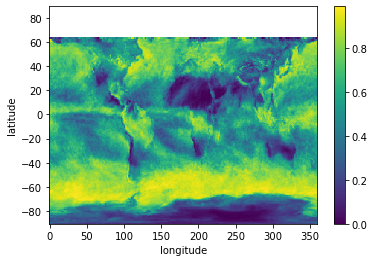

In [187]:
test.sum(dim=['COT','PRES']).where(test.cloud_mask).plot()

In [174]:
out_test = xr.open_dataset('%s/%s' % ('/glade/u/home/jonahshaw/w/obs/MODIS/processed_histograms',chey_modis_file))

In [176]:
out_test['__xarray_dataarray_variable__']

<xarray.DataArray '__xarray_dataarray_variable__' (latitude: 180, longitude: 360, COT: 7, PRES: 7)>
[3175200 values with dtype=float64]
Dimensions without coordinates: latitude, longitude, COT, PRES
Attributes:
    title:                                  Cloud_Optical_Thickness_Total: JH...
    JHisto_Bin_Boundaries:                  [  0.    0.3   1.3   3.6   9.4  2...
    JHisto_Bin_Boundaries_Joint_Parameter:  [    0.   180.   310.   440.   56...

In [ ]:
'/glade/u/home/jonahshaw/w/obs/MODIS/processed_histograms'

In [166]:
test = open_groups(chey_modis_filepath)

In [169]:
cldthck = test[:,:,-2:,:3].sum(dim=['COT','PRES'])

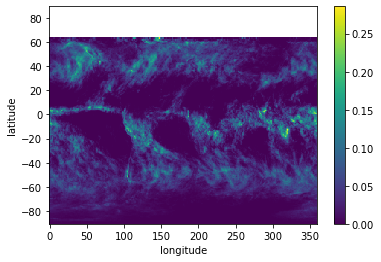

In [171]:
cldthck.where(cldthck['cloud_mask']).plot()

In [152]:
test.COT.assign_

<xarray.DataArray 'COT' (COT: 7)>
array([0, 1, 2, 3, 4, 5, 6])
Dimensions without coordinates: COT

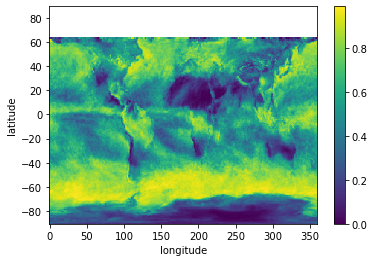

In [118]:
test.sum(dim=['PRES','COT']).where(test['cloud_mask']).plot()

In [126]:
test.PRES

<xarray.DataArray 'PRES' (PRES: 7)>
array([0, 1, 2, 3, 4, 5, 6])
Dimensions without coordinates: PRES

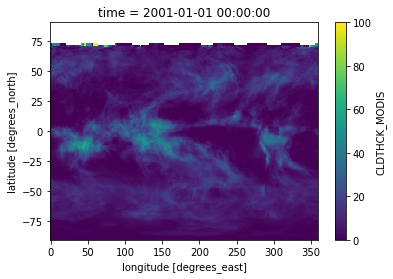

In [121]:
ex_file['CLDTHCK_MODIS'][2].plot()

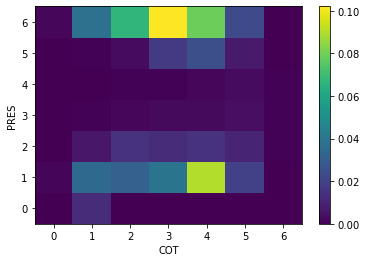

In [53]:
test[50,50,:,:].plot()

In [143]:
cot_climo['JHisto_vs_Cloud_Top_Pressure'].attrs

{'title': 'Cloud_Optical_Thickness_Total: JHisto_vs_Cloud_Top_Pressure',
 'JHisto_Bin_Boundaries': array([  0. ,   0.3,   1.3,   3.6,   9.4,  23. ,  60. , 150. ]),
 'JHisto_Bin_Boundaries_Joint_Parameter': array([    0.,   180.,   310.,   440.,   560.,   680.,   800., 10000.])}

In [123]:
cot_climo = xr.open_dataset(chey_modis_filepath,group='Cloud_Optical_Thickness_Total',engine='netcdf4')
cotpcl_climo = xr.open_dataset(chey_modis_filepath,group='Cloud_Optical_Thickness_PCL_Total',engine='netcdf4')
# cldtot_climo = xr.open_dataset(chey_modis_filepath,group='Cloud_Mask_Fraction',engine='netcdf4')
# cldhgh_climo = xr.open_dataset(chey_modis_climopath,group='Cloud_Mask_Fraction_High',engine='netcdf4')
cld_denom = xr.open_dataset(chey_modis_filepath,group='Cloud_Retrieval_Fraction_Total',engine='netcdf4')


In [125]:
cot_climo

<xarray.Dataset>
Dimensions:                       (jhisto_cloud_optical_thickness_total_7: 7, jhisto_cloud_top_pressure_7: 7, latitude: 180, longitude: 360)
Dimensions without coordinates: jhisto_cloud_optical_thickness_total_7, jhisto_cloud_top_pressure_7, latitude, longitude
Data variables:
    Mean                          (longitude, latitude) float64 ...
    Standard_Deviation            (longitude, latitude) float64 ...
    Sum                           (longitude, latitude) float64 ...
    Pixel_Counts                  (longitude, latitude) float64 ...
    Sum_Squares                   (longitude, latitude) float64 ...
    JHisto_vs_Cloud_Top_Pressure  (longitude, latitude, jhisto_cloud_optical_thickness_total_7, jhisto_cloud_top_pressure_7) float64 ...
Attributes:
    long_name:     Cloud Optical Thickness for Combined (LiquidWater+Ice+Unde...
    units:         none
    _FillValue:    -999.0
    valid_min:     0.0
    valid_max:     150.0
    scale_factor:  1.0
    add_offset:    0.0

In [39]:
cot_counts = cot_climo['JHisto_vs_Cloud_Top_Pressure'].sum(dim=['jhisto_cloud_optical_thickness_total_7','jhisto_cloud_top_pressure_7'])
cotpcl_counts = cotpcl_climo['JHisto_vs_Cloud_Top_Pressure'].sum(dim=['jhisto_cloud_optical_thickness_pcl_total_7','jhisto_cloud_top_pressure_7'])

I don't understand why there is a peak at ~10 degrees (oh maybe this is the orbit angle of MODIS!).

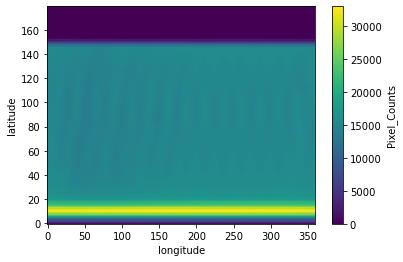

In [40]:
cld_denom['Pixel_Counts'].transpose("latitude", "longitude").plot()

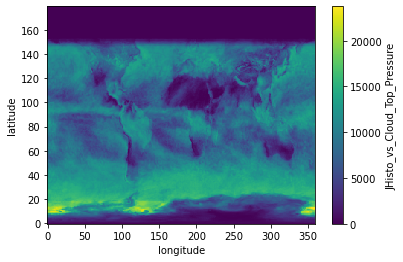

In [41]:
(cot_counts + cotpcl_counts).transpose("latitude", "longitude").plot()

This is gorgeous and has the right bounds, yay!

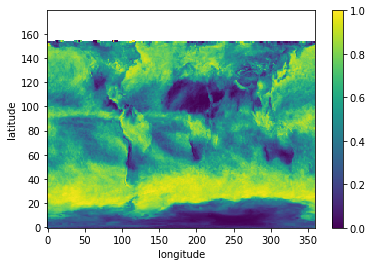

In [42]:
((cot_counts + cotpcl_counts) / cld_denom['Pixel_Counts']).transpose("latitude", "longitude").plot()

### Work with the averaged MODIS climatology from Jen (2003-2020)

Because of the organization of these files, we need to open them using the group command in xarray and the 'netcdf4' background engine.

#### Load the total cloud histogram, total cloud mask, and high cloud histogram

In [7]:
cot_climo = xr.open_dataset(chey_modis_climopath,group='Cloud_Optical_Thickness_Total',engine='netcdf4')
cotpcl_climo = xr.open_dataset(chey_modis_climopath,group='Cloud_Optical_Thickness_PCL_Total',engine='netcdf4')
cldtot_climo = xr.open_dataset(chey_modis_climopath,group='Cloud_Mask_Fraction',engine='netcdf4')
# cldhgh_climo = xr.open_dataset(chey_modis_climopath,group='Cloud_Mask_Fraction_High',engine='netcdf4')
cld_denom = xr.open_dataset(chey_modis_climopath,group='Cloud_Retrieval_Fraction_Total',engine='netcdf4')


In [16]:
cot_counts = cot_climo['JHisto_vs_Cloud_Top_Pressure'].sum(dim=['jhisto_cloud_optical_thickness_total_7','jhisto_cloud_top_pressure_7'])
cotpcl_counts = cotpcl_climo['JHisto_vs_Cloud_Top_Pressure'].sum(dim=['jhisto_cloud_optical_thickness_pcl_total_7','jhisto_cloud_top_pressure_7'])

"For this, I think your Option #1 is correct, using the sum of the non-PCL and PCL Cloud_Optical_Thickness joint histograms (vs CTP) as the numerator, and Cloud_Retrieval_Fraction_Total Pixel_Counts as the denominator.

__This denominator is causing some of the striping seen in the plot below this one, so I don't like it.__  

Why is there an increase in retrievals at high latitudes in the NH and not in the SH? To what extent will restricting our analysis to 60S-60N resolve this?

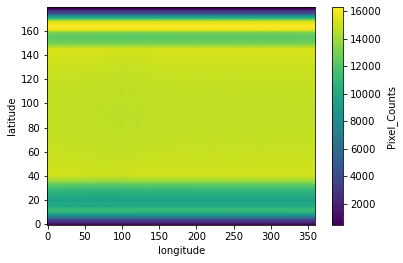

In [17]:
cld_denom['Pixel_Counts'].transpose("latitude", "longitude").plot()

In [24]:
pixel_count_zonemean = cld_denom['Pixel_Counts'].mean('longitude')

Restricting our analysis to 60S-60N still includes these areas where the retrieval count falls off rapidly (due to fewer retrievals by passive sensors in the winter).

__This results in part from working with the climatology. What would happen if I worked with individual monthly files?.__

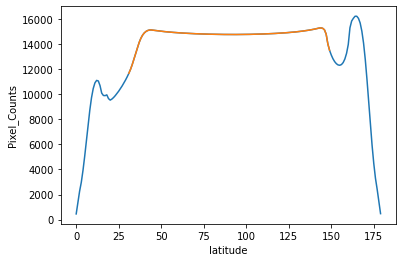

In [27]:
pixel_count_zonemean.plot()
pixel_count_zonemean.where(np.abs(pixel_count_zonemean['latitude']-90)<60).plot()

__There is also striping in the numerator, which we would maybe expect to just be a gradient, but the quotient doesn't resolve it.__

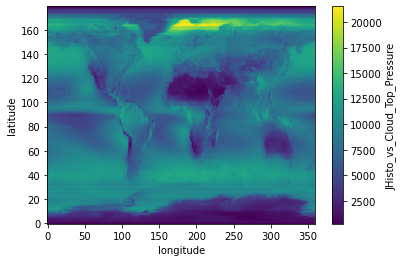

In [20]:
(cot_counts + cotpcl_counts).transpose("latitude", "longitude").plot()

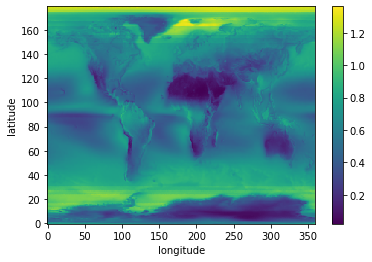

In [18]:
((cot_counts + cotpcl_counts) / cld_denom['Pixel_Counts']).transpose("latitude", "longitude").plot()

Taking out the PCL scenarios does not resolve the over 100% cloud fraction issue, which seems to be localizeed to the North Atlantic.

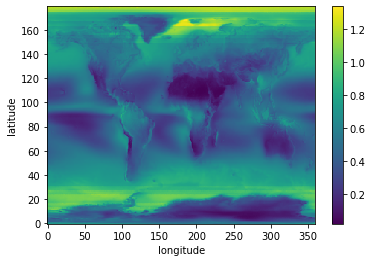

In [23]:
((cot_counts) / cld_denom['Pixel_Counts']).transpose("latitude", "longitude").plot()

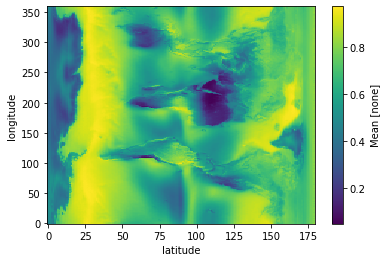

In [5]:
cldtot_climo['Mean'].plot()

#### Select the bins corresponding to high-topped, thick clouds

In [6]:
cot_climo['JHisto_vs_Cloud_Top_Pressure']

<xarray.DataArray 'JHisto_vs_Cloud_Top_Pressure' (longitude: 360, latitude: 180, jhisto_cloud_optical_thickness_total_7: 7, jhisto_cloud_top_pressure_7: 7)>
[3175200 values with dtype=float64]
Dimensions without coordinates: longitude, latitude, jhisto_cloud_optical_thickness_total_7, jhisto_cloud_top_pressure_7
Attributes:
    title:                                  Cloud_Optical_Thickness_Total: JH...
    JHisto_Bin_Boundaries:                  [  0.    0.3   1.3   3.6   9.4  2...
    JHisto_Bin_Boundaries_Joint_Parameter:  [    0.   180.   310.   440.   56...

In [16]:
cot_climo['JHisto_vs_Cloud_Top_Pressure'][:,:,5:,:3]

<xarray.DataArray 'JHisto_vs_Cloud_Top_Pressure' (longitude: 360, latitude: 180, jhisto_cloud_optical_thickness_total_7: 2, jhisto_cloud_top_pressure_7: 3)>
array([[[[0., ..., 1.],
         [1., ..., 4.]],

        ...,

        [[0., ..., 3.],
         [0., ..., 4.]]],


       ...,


       [[[0., ..., 1.],
         [1., ..., 4.]],

        ...,

        [[0., ..., 3.],
         [0., ..., 4.]]]])
Dimensions without coordinates: longitude, latitude, jhisto_cloud_optical_thickness_total_7, jhisto_cloud_top_pressure_7
Attributes:
    title:                                  Cloud_Optical_Thickness_Total: JH...
    JHisto_Bin_Boundaries:                  [  0.    0.3   1.3   3.6   9.4  2...
    JHisto_Bin_Boundaries_Joint_Parameter:  [    0.   180.   310.   440.   56...

In [17]:
highthick_counts = cot_climo['JHisto_vs_Cloud_Top_Pressure'][:,:,5:,:3].sum(['jhisto_cloud_optical_thickness_total_7','jhisto_cloud_top_pressure_7']).transpose("latitude", "longitude")

all_counts = cot_climo['JHisto_vs_Cloud_Top_Pressure'].sum(['jhisto_cloud_optical_thickness_total_7','jhisto_cloud_top_pressure_7']).transpose("latitude", "longitude")
hgh_counts = cot_climo['JHisto_vs_Cloud_Top_Pressure'][:,:,:,:3].sum(['jhisto_cloud_optical_thickness_total_7','jhisto_cloud_top_pressure_7']).transpose("latitude", "longitude")

cldtot = cldtot_climo['Mean'].transpose("latitude", "longitude")
cldhgh = cldhgh_climo['Mean'].transpose("latitude", "longitude")

In [18]:
highthick_cld1 = (highthick_counts/all_counts*cldtot) # assume the counts all correspond to equal coverage using total cloud mask

highthick_cld2 = (highthick_counts/hgh_counts*cldhgh) # assume the counts all correspond to equal coverage using total cloud mask

#### This is definitely wrong. No signal from the ICTZ.

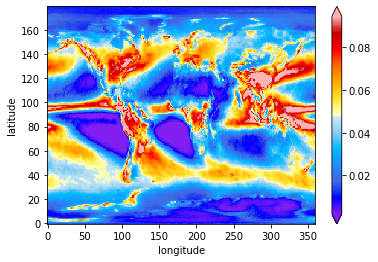

In [28]:
highthick_cld1.plot(cmap=cmaps.ncl_default,robust=True)

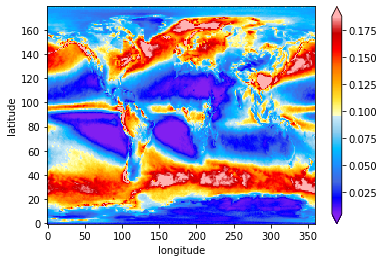

In [27]:
highthick_cld2.plot(cmap=cmaps.ncl_default,robust=True)

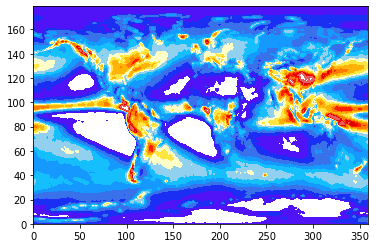

In [25]:
plt.contourf(highthick_cld1,cmap=cmaps.ncl_default,levels=np.linspace(0.01,0.13,14))

#### This value is also clearly wrong.

In [21]:
test1 = add_weights(highthick_cld1)

In [22]:
mean = masked_average(test1,weights=test1['cell_weight'])

In [23]:
mean

<xarray.DataArray ()>
array(-0.28124583)

### Open a single file for processing into cloud histograms (I did this locally, so it won't work on Cheyenne)

In [3]:
os.getcwd()

'/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/CESM2_COSP'

In [4]:
ls /Users/jonahshaw/Desktop/rsyncd/

ls: cannot access /Users/jonahshaw/Desktop/rsyncd/: No such file or directory


In [4]:
single_modis_path = '/Users/jonahshaw/Desktop/rsyncd/MCD06COSP_M3_MODIS.A2020001.061.2020181150624.nc'
group = 'Cloud_Optical_Thickness_Total'

In [17]:
xr.open_dataset

<function xarray.backends.api.open_dataset(filename_or_obj, group=None, decode_cf=True, mask_and_scale=None, decode_times=True, autoclose=None, concat_characters=True, decode_coords=True, engine=None, chunks=None, lock=None, cache=None, drop_variables=None, backend_kwargs=None, use_cftime=None, decode_timedelta=None)>

In [56]:
single_modis = xr.open_dataset(single_modis_path,group=group,engine='netcdf4')
single_modis_fraction = xr.open_dataset(single_modis_path,group='Cloud_Mask_Fraction',engine='netcdf4')
single_modis_fractionh = xr.open_dataset(single_modis_path,group='Cloud_Mask_Fraction_High',engine='netcdf4')

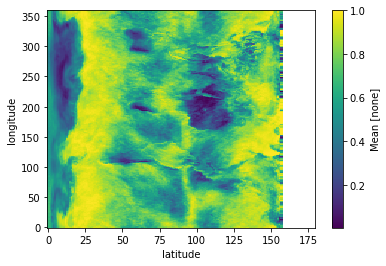

In [55]:
single_modis_fraction['Mean'].plot()

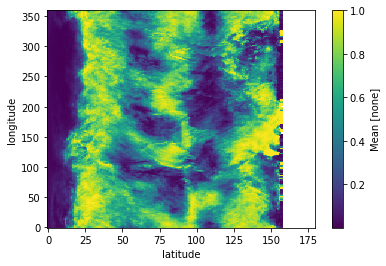

In [57]:
single_modis_fractionh['Mean'].plot() # Cloud Fraction from Cloud Mask (High, CTP LT 440 hPa) for Daytime Scenes

There are several interesting variables here that might be useful in calculating cloud amount:

Mean 'Cloud_Optical_Thickness_Total: Mean': (goes from 0 to 150)  
Sum 'Cloud_Optical_Thickness_Total: Sum' (goes from 0 to 1e6)  
Pixel_Counts 'Cloud_Optical_Thickness_Total: Pixel_Counts' (0 to ~25000)  
Sum_Squares 'Cloud_Optical_Thickness_Total: Sum_Squares' (0 to 1e8)  


In [50]:
print('Sum: ',single_modis['Sum'][0,0].values)

print('Mean: ',single_modis['Mean'][0,0].values)

print('Pixel_Counts: ',single_modis['Pixel_Counts'][0,0].values) # same as summing over the bins

print('Sum_Squares: ',single_modis['Sum_Squares'][0,0].values)


Sum:  4277.099904496223
Mean:  7.451393561840109
Pixel_Counts:  574.0
Sum_Squares:  139689.92274126093


So 'mean' is the average optical depth of the observed clouds.  

'Pixel_Counts' is the counts of the sampled L2 pixels in each L3 grid. (L2 is higher resolution? This is the sum over the bins.)

'Sum' is the sum of the values of the L2 pixels in each L3 grid. (so 'Sum'/'Pixel_Counts' should give 'Mean')

'Sum_Squares' is the sum of the squares of the values of the L2 pixels in each L3 grid (so this is more statistics like and probably useless for me)

I could potentially derived the low-thick clouds by calculating the counts in those bins relative to the total counts and multiplying by the total cloud fraction mask, but that assumes that the clouds fraction for each retrieval is identical (maybe ok on small domains where a gridcell is just 'cloudy' or 'cloud-free', but probably not the best option. I will probably end up reaching out to Robert Pincus.

In [45]:
single_modis['Mean'][0,0]

<xarray.DataArray 'Mean' ()>
array(7.451394)
Attributes:
    title:    Cloud_Optical_Thickness_Total: Mean
    units:    none

In [ ]:
point0 = single_modis

In [22]:
single_modis['JHisto_vs_Cloud_Top_Pressure'].shape

(360, 180, 7, 7)

In [25]:
test_histo = single_modis['JHisto_vs_Cloud_Top_Pressure'][0,0,:,:]

In [28]:
test_histo.attrs

{'title': 'Cloud_Optical_Thickness_Total: JHisto_vs_Cloud_Top_Pressure',
 'JHisto_Bin_Boundaries': array([  0. ,   0.3,   1.3,   3.6,   9.4,  23. ,  60. , 150. ]),
 'JHisto_Bin_Boundaries_Joint_Parameter': array([    0.,   180.,   310.,   440.,   560.,   680.,   800., 10000.])}

In [38]:
test_histo.sum()

<xarray.DataArray 'JHisto_vs_Cloud_Top_Pressure' ()>
array(574.)

Text(0.5, 1.0, 'Cloud_Optical_Thickness_Total: JHisto_vs_Cloud_Top_Pressure')

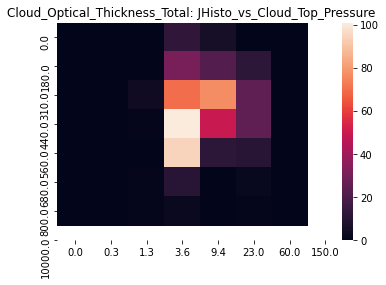

In [34]:
# import numpy as np; 
np.random.seed(0)
# import seaborn as sns; 
# sns.set_theme()
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(test_histo,yticklabels=test_histo.attrs['JHisto_Bin_Boundaries_Joint_Parameter'],
                 xticklabels=test_histo.attrs['JHisto_Bin_Boundaries'])

ax.set_title(test_histo.attrs['title'])
# plt.ticklabels(test_histo.attrs['JHisto_Bin_Boundaries_Joint_Parameter'])

## Process MODIS observations

#### There is no time coordinate in this climatology

In [5]:
modis_dir = '/glade/u/home/jonahshaw/w/obs/MODIS/nasa_data'
climo_file = 'MCD06COSP_M3_MODIS.200207_202006_CLIMO.nc'


### The files are group-nested, so they require an additional argument when loading using xarray

In [36]:
# from netCDF4 import Dataset

# source_dataset = Dataset('%s/%s' % (modis_dir,climo_file))
# source_geo_group = source_dataset['/Cloud_Optical_Thickness_PCL_Total/']

Load the correct group.

In [21]:
cloud_histo = xr.open_dataset('%s/%s' % (modis_dir,climo_file),group='Cloud_Optical_Thickness_PCL_Total')

In [25]:
cloud_histo['JHisto_vs_Cloud_Top_Pressure']

<xarray.DataArray 'JHisto_vs_Cloud_Top_Pressure' (longitude: 360, latitude: 180, jhisto_cloud_optical_thickness_pcl_total_7: 7, jhisto_cloud_top_pressure_7: 7)>
[3175200 values with dtype=float64]
Dimensions without coordinates: longitude, latitude, jhisto_cloud_optical_thickness_pcl_total_7, jhisto_cloud_top_pressure_7
Attributes:
    title:                                  Cloud_Optical_Thickness_PCL_Total...
    JHisto_Bin_Boundaries:                  [  0.    0.3   1.3   3.6   9.4  2...
    JHisto_Bin_Boundaries_Joint_Parameter:  [    0.   180.   310.   440.   56...

In [28]:
total_cloud = cloud_histo['JHisto_vs_Cloud_Top_Pressure'].sum(dim=['jhisto_cloud_optical_thickness_pcl_total_7','jhisto_cloud_top_pressure_7'])

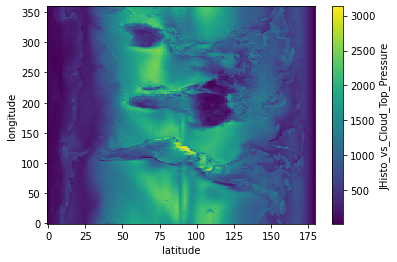

In [30]:
total_cloud.plot()

In [35]:
cloud_histo['JHisto_vs_Cloud_Top_Pressure'][:,:,5:,:3].shape

(360, 180, 2, 3)

In [19]:
source_geo_group.

<class 'netCDF4._netCDF4.Group'>
group /Cloud_Optical_Thickness_PCL_Total:
    long_name: Cloud Optical Thickness for Combined (LiquidWater+Ice+Undetermined) Phase Clouds (3.7 micron Retrieval for Partly Cloudy (PCL) Scenes)
    units: none
    _FillValue: -999.0
    valid_min: 0.0
    valid_max: 150.0
    scale_factor: 1.0
    add_offset: 0.0
    dimensions(sizes): 
    variables(dimensions): int32 JHisto_vs_Cloud_Top_Pressure(longitude,latitude,jhisto_cloud_optical_thickness_pcl_total_7,jhisto_cloud_top_pressure_7)
    groups: 

In [4]:
ls $modis_dir

checksums_501605512
make_avg.csh*
MCD06COSP_M3_MODIS.200207_202006.nc
MCD06COSP_M3_MODIS.A2002182.061.2020181145824.nc
MCD06COSP_M3_MODIS.A2002213.061.2020181145836.nc
MCD06COSP_M3_MODIS.A2002244.061.2020181145835.nc
MCD06COSP_M3_MODIS.A2002274.061.2020181145834.nc
MCD06COSP_M3_MODIS.A2002305.061.2020181145842.nc
MCD06COSP_M3_MODIS.A2002335.061.2020181145833.nc
MCD06COSP_M3_MODIS.A2003001.061.2020181145828.nc
MCD06COSP_M3_MODIS.A2003032.061.2020181145826.nc
MCD06COSP_M3_MODIS.A2003060.061.2020181145844.nc
MCD06COSP_M3_MODIS.A2003091.061.2020181145836.nc
MCD06COSP_M3_MODIS.A2003121.061.2020181145829.nc
MCD06COSP_M3_MODIS.A2003152.061.2020181145835.nc
MCD06COSP_M3_MODIS.A2003182.061.2020181145902.nc
MCD06COSP_M3_MODIS.A2003213.061.2020181145916.nc
MCD06COSP_M3_MODIS.A2003244.061.2020181145926.nc
MCD06COSP_M3_MODIS.A2003274.061.2020181145913.nc
MCD06COSP_M3_MODIS.A2003305.061.2020181145915.nc
MCD06COSP_M3_MODIS.A2003335.061.2020181145902.nc
MCD06COSP_M3_MODIS.A2004001.061.2020181145906.nc

In [4]:
modis_old = xr.open_dataset('%s/%s' % (modis_dir,'MCD03_M3_NC_200207to201007.V01.nc'))

In [10]:
modis_old

<xarray.Dataset>
Dimensions:                                                  (Cloud_Optical_Thickness: 7, Cloud_Top_Pressure: 7, lat: 180, lon: 360, nbnds: 2)
Coordinates:
  * lat                                                      (lat) float32 89...
  * lon                                                      (lon) float32 -1...
  * Cloud_Optical_Thickness                                  (Cloud_Optical_Thickness) float32 ...
  * Cloud_Top_Pressure                                       (Cloud_Top_Pressure) float32 ...
Dimensions without coordinates: nbnds
Data variables:
    Cloud_Optical_Thickness_bnds                             (nbnds, Cloud_Optical_Thickness) float32 ...
    Cloud_Top_Pressure_bnds                                  (nbnds, Cloud_Top_Pressure) float32 ...
    Cloud_Top_Pressure_Total_Mean                            (lat, lon) float32 ...
    Cloud_Fraction_Mask_Total_Mean                           (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Mean                      (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Uncertainty_in_Mean       (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_Uncertainty_in_MeanLog10  (lat, lon) float32 ...
    Cloud_Optical_Thickness_Liquid_MeanLog10                 (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Mean                         (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Uncertainty_in_Mean          (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_Uncertainty_in_MeanLog10     (lat, lon) float32 ...
    Cloud_Optical_Thickness_Ice_MeanLog10                    (lat, lon) float32 ...
    Cloud_Optical_Thickness_Total_Mean                       (lat, lon) float32 ...
    Cloud_Optical_Thickness_Total_MeanLog10                  (lat, lon) float32 ...
    Optical_Thickness_vs_Cloud_Top_Pressure                  (lat, lon, Cloud_Top_Pressure, Cloud_Optical_Thickness) float32 ...
    Cloud_Particle_Size_Liquid_Mean                          (lat, lon) float32 ...
    Cloud_Particle_Size_Liquid_Uncertainty_in_Mean           (lat, lon) float32 ...
    Cloud_Particle_Size_Ice_Mean                             (lat, lon) float32 ...
    Cloud_Particle_Size_Ice_Uncertainty_in_Mean              (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Liquid_Mean                     (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Ice_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Total_Mean                      (lat, lon) float32 ...
    Liquid_Path_Mean                                         (lat, lon) float32 ...
    Liquid_Path_Uncertainty_in_Mean                          (lat, lon) float32 ...
    Ice_Path_Mean                                            (lat, lon) float32 ...
    Ice_Path_Uncertainty_in_Mean                             (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_High_Mean                       (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Mid_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Retrieval_Low_Mean                        (lat, lon) float32 ...
    Cloud_Fraction_Mask_High_Mean                            (lat, lon) float32 ...
    Cloud_Fraction_Mask_Mid_Mean                             (lat, lon) float32 ...
    Cloud_Fraction_Mask_Low_Mean                             (lat, lon) float32 ...
Attributes:
    Retrieval_Version:         Collection 51
    Begin_Date:                2002-07-01
    Conventions:               CF-1.4
    Title:                     MODIS cloud observations for climate model eva...
    history:                   Wed Apr  6 15:17:35 2011: ncea -O MCD03_M3_NC....
    nco_openmp_thread_number:  1

### Load CAM data for interpolation

In [5]:
case_dir = '/glade/scratch/jonahshaw/archive/Kay_COSP_2012/'

cam4metric = Cloud_Metric(case_dir)
cam4metric.add_case('cam4_1deg_release_amip',label='CAM4')

Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Processed timeseries directory found for cam4_1deg_release_amip. Will load data as required.
cam4_1deg_release_amip load successfully.


### Plot to trigger variable loading

Could not find variable in GOCCP or CERES-EBAF datasets.


SystemExit: 

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


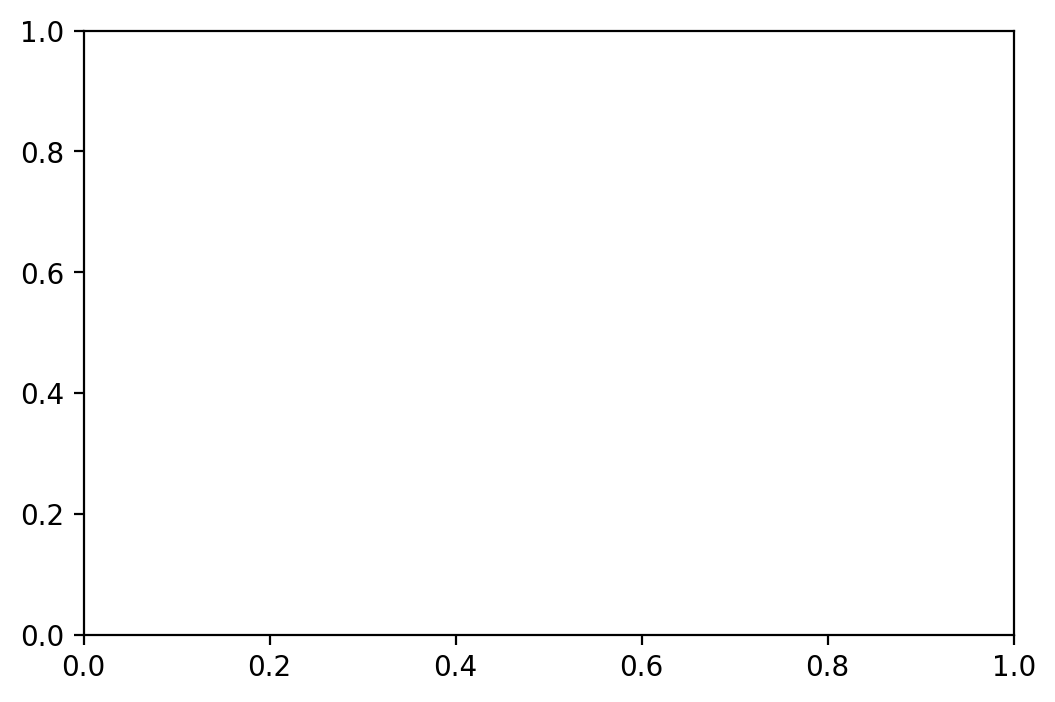

In [7]:
cam4metric.plot1D('CLMODIS');

____

In [8]:
cam4da = cam4metric.get_case('cam4_1deg_release_amip').case_da

In [9]:
cam4da['CLMODIS']

<xarray.DataArray 'CLMODIS' (time: 122, cosp_prs: 7, cosp_tau_modis: 6, lat: 192, lon: 288)>
[283336704 values with dtype=float32]
Coordinates:
  * cosp_prs        (cosp_prs) float64 900.0 740.0 620.0 500.0 375.0 245.0 90.0
  * cosp_tau_modis  (cosp_tau_modis) float64 0.8 2.45 6.5 16.2 41.5 5.003e+04
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 2000-12-01 00:00:00 ... 2011-01-01 00:00:00
Attributes:
    mdims:         [12  3]
    units:         %
    long_name:     MODIS Cloud Area Fraction
    cell_methods:  time: mean

## Interpolate to the CAM grid

In [29]:
modis_old_interpd,_ = interp_like2D(modis_old,cam4da['CLMODIS'])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xesmf/smm.py:98: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


### Copy over dataset-wide attributes

In [30]:
attrs = modis_old.attrs
# print(attrs['Comments'])

datestamp = datetime.today().strftime("%Y/%m/%d")
attrs['Comments'] = 'Interpolated to 1.25x1 deg CESM grid by Jonah Shaw (CU) on %s.' % datestamp
# print(attrs['Comments'])
modis_old_interpd = modis_old_interpd.assign_attrs(attrs)

### Create fake time coordinate.

In [31]:
modis_old_interpd = modis_old_interpd.assign_coords({'time':1})

modis_old_interpd['time'].attrs['calendar'] = '360_day'
modis_old_interpd['time'].attrs['units'] = "months since 1999-12-01"

modis_old_interpd = xr.decode_cf(modis_old_interpd)

In [5]:
save_dir = '/glade/work/jonahshaw/obs/MODIS/'
filename = 'MCD03_M3_NC_200207to201007.V01.nc'

In [35]:
modis_old_interpd.to_netcdf("%s/%s" % (save_dir,filename))

In [6]:
modis_old_interpd = xr.open_dataset("%s/%s" % (save_dir,filename))

In [37]:
cam4da['CLMODIS']

<xarray.DataArray 'CLMODIS' (time: 122, cosp_prs: 7, cosp_tau_modis: 6, lat: 192, lon: 288)>
[283336704 values with dtype=float32]
Coordinates:
  * cosp_prs        (cosp_prs) float64 900.0 740.0 620.0 500.0 375.0 245.0 90.0
  * cosp_tau_modis  (cosp_tau_modis) float64 0.8 2.45 6.5 16.2 41.5 5.003e+04
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 2000-12-01 00:00:00 ... 2011-01-01 00:00:00
Attributes:
    mdims:         [12  3]
    units:         %
    long_name:     MODIS Cloud Area Fraction
    cell_methods:  time: mean

In [ ]:
{'Optical_Thickness_vs_Cloud_Top_Pressure':'CLMODIS',}

cam4_1deg_release_amip.cam.h0.CLHMODIS.200011-201012.nc         
cam4_1deg_release_amip.cam.h0.LWPMODIS.200011-201012.nc           
cam4_1deg_release_amip.cam.h0.TAUWMODIS.200011-201012.nc  

cam4_1deg_release_amip.cam.h0.CLIMODIS.200011-201012.nc   
cam4_1deg_release_amip.cam.h0.CLLMODIS.200011-201012.nc  

cam4_1deg_release_amip.cam.h0.CLMMODIS.200011-201012.nc  


cam4_1deg_release_amip.cam.h0.CLMODIS.200011-201012.nc 

cam4_1deg_release_amip.cam.h0.TAUILOGMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.TAUIMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.IWPMODIS.200011-201012.nc          
cam4_1deg_release_amip.cam.h0.TAUTLOGMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.TAUTMODIS.200011-201012.nc  
cam4_1deg_release_amip.cam.h0.TAUWLOGMODIS.200011-201012.nc  

In [8]:
modis_vars_dict = {'Cloud_Fraction_Retrieval_Total_Mean':'CLTMODIS',
                   'Cloud_Fraction_Retrieval_Low_Mean':'CLLMODIS',
                   'Cloud_Fraction_Retrieval_Mid_Mean':'CLMMODIS',
                   'Cloud_Fraction_Retrieval_High_Mean':'CLHMODIS',
                   'Cloud_Fraction_Retrieval_Liquid_Mean':'CLWMODIS',
                   'Cloud_Fraction_Retrieval_Ice_Mean':'CLIMODIS',
                   'Optical_Thickness_vs_Cloud_Top_Pressure':'CLMODIS',
                   'Liquid_Path_Mean':'LWPMODIS',
                   'Ice_Path_Mean':'IWPMODIS',
                   'Cloud_Optical_Thickness_Liquid_Mean':'TAUWMODIS',
                   'Cloud_Optical_Thickness_Liquid_MeanLog10':'TAUWLOGMODIS',
                   'Cloud_Optical_Thickness_Ice_MeanLog10':'TAUILOGMODIS',
                   'Cloud_Optical_Thickness_Ice_Mean':'TAUIMODIS',
                   'Cloud_Optical_Thickness_Total_Mean':'TAUTMODIS',
                   'Cloud_Optical_Thickness_Total_MeanLog10':'TAUTLOGMODIS',
                   'Cloud_Top_Pressure_Total_Mean':'PCTMODIS',
                   'Cloud_Particle_Size_Liquid_Mean':'REFFCLWMODIS',
                   'Cloud_Particle_Size_Ice_Mean':'REFFCLIMODIS',}


In [11]:
modis_final = modis_old_interpd.rename(modis_vars_dict)

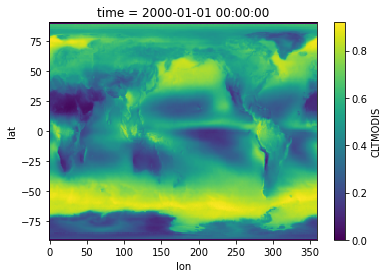

In [14]:
modis_final['CLTMODIS'].plot()